In [12]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [13]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [14]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p)
        if collFree == False: return False

    return collFree

In [15]:
def draw_map(obstacles):
    # Obstacles. An obstacle is represented as a convex hull of a number of points.
    # First row is x, second is y (position of vertices)

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]

    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]))
        #ax.add_patch(patch)

    plt.show()

In [16]:
#w = 0.2
#obstacles = [
#              np.array([[0, -1], [1, -1], [1, -0.9], [0, w-1]]),
#              np.array([[0, -1], [w, -0.8], [0.1, 1], [0.0, 1.0]]),
#              np.array([[0, 1-w], [1, 1], [1, 1+w], [0, 1+w]]),
#              np.array([[1-w, -1], [1+w, -1], [1+w, 0], [1, 0]]),
#              np.array([[1-w, 1+w], [1+w, 1+w], [1+w, 0.5], [1, 0.5]]),
#              np.array([[0.8, 0], [1+w, 0], [1+w, w], [0.8, w]]),
#              np.array([[0.8, 0.5], [1+w, 0.5], [1+w, 0.5+w], [0.8, 0.5+w]]),
#
#              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),
#
#              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
#            ]
#draw_map(obstacles)

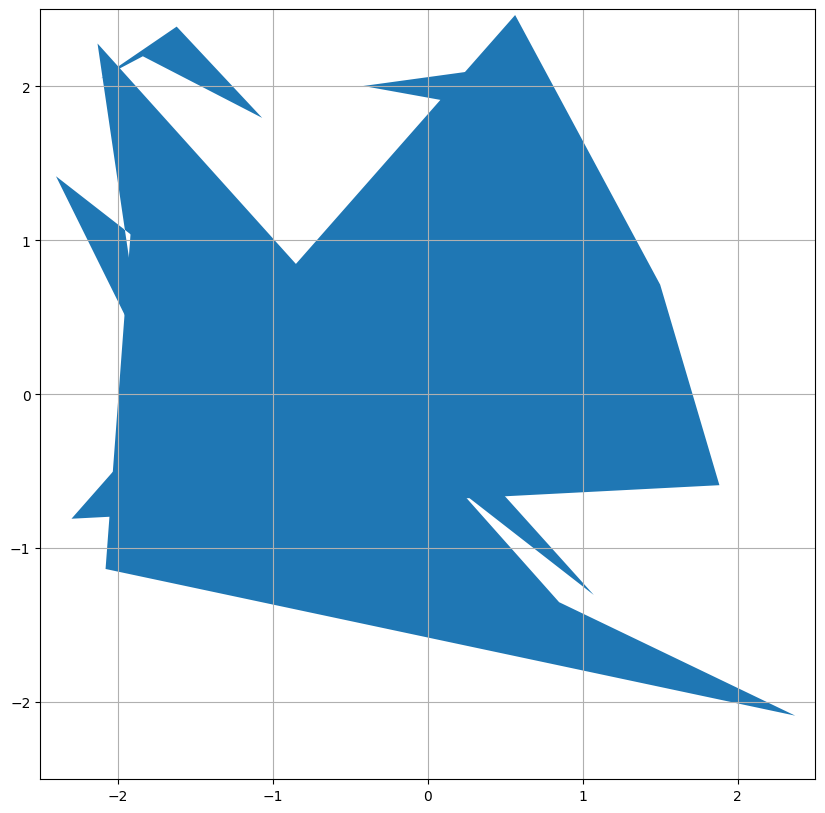

In [17]:
obstacles = []

for i in range(5):
    polygon = np.array([[random()*5-2.5, random()*5-2.5], [random()*5-2.5, random()*5-2.5], [random()*5-2.5, random()*5-2.5], [random()*5-2.5, random()*5-2.5]])
    obstacles.append(polygon)

draw_map(obstacles)

In [18]:
obstacles

[array([[-2.39827695,  1.41580792],
        [ 1.07153279, -1.30319415],
        [-2.13035117,  2.27785716],
        [-1.83877205,  0.2787542 ]]),
 array([[-2.29829513, -0.80810062],
        [ 0.56395534,  2.46256145],
        [ 1.49969076,  0.71160418],
        [ 1.88190867, -0.59029909]]),
 array([[-1.06793542,  1.79460847],
        [-1.61971072,  2.3875295 ],
        [-2.11061375,  2.05015389],
        [-1.83778865,  2.19481876]]),
 array([[-2.07846837, -1.13438704],
        [-1.86673573,  1.7219975 ],
        [ 0.84777266, -1.35011771],
        [ 2.37094654, -2.08686837]]),
 array([[ 1.32818713, -0.14527694],
        [ 0.4572668 ,  1.84340591],
        [-0.4155898 ,  2.0018838 ],
        [ 0.24752265,  2.09339895]])]

In [19]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [20]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

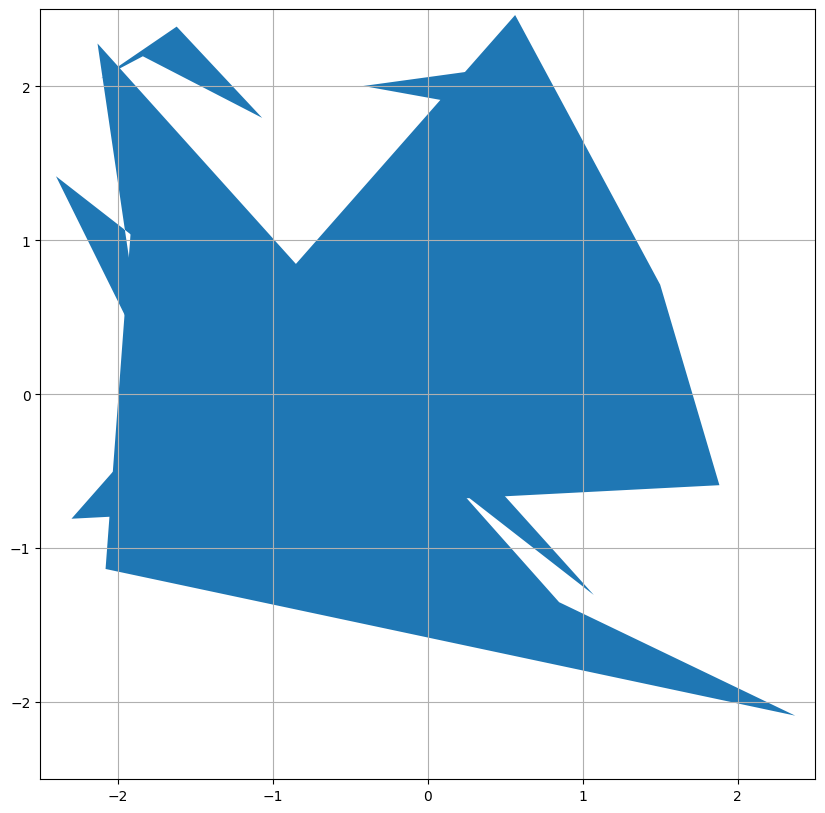

<ipython-input-21-8a94989832b5>:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES


Reached the goal after 118.85 seconds:
Number of iterations passed: 28370 / 200000
RRT length:  6339
Constructing the path...
Reached RRT start node


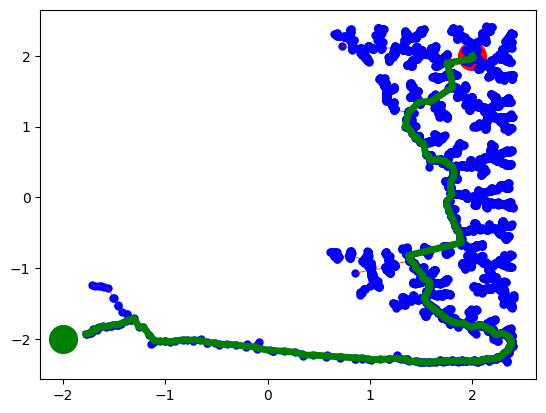

In [21]:
visualize = 1
maxiters  = 200000
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.25 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.05 # Extension parameter: this controls how far the RRT extends in each step.

draw_map(obstacles)

xy_start = np.array([2, 2])
xy_goal  = np.array([-2.0, -2.0])

# Start and goal positions
plt.plot(xy_start[0],xy_start[1],'o',color='red', markersize=20)
plt.plot(xy_goal[0], xy_goal[1], 'o',color='green', markersize=20)

# Initialize RRT. The RRT will be represented as a 2 x N list of points.
# So each column represents a vertex of the tree.
rrt = []
start_node = Node()
start_node.p = xy_start
start_node.i = 0
start_node.iPrev = 0
rrt.append(start_node)


# RRT algorithm
start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    # Sample point
    rnd = random()
    # With probability 0.05, sample the goal. This promotes movement to the goal.
    if rnd < 0.05:
        xy = xy_goal
    else:
        # Sample (uniformly) from space (with probability 0.95). The space is defined
        # with the bounds world_bounds_x and world_bounds_y defined above.
        # So, the x coordinate should be sampled in the interval
        # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
        xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
    # Check if sample is collision free
    collFree = isCollisionFreeVertex(obstacles, xy)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

    # If it is collision free, find closest point in existing tree.
    closest_node = closestNode(rrt, xy)

    # Extend tree towards xy from closest_vert. Use the extension parameter
    # d defined above as your step size. In other words, the Euclidean
    # distance between new_vert and closest_vert should be d.
    new_node = Node()
    new_node.p = closest_node.p + d * (xy - closest_node.p)
    new_node.i = len(rrt)
    new_node.iPrev = closest_node.i

    # Check if new vertice is in collision
    collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

        # If it is collision free, add it to tree
    rrt.append(new_node)

    if visualize:
        # plt.plot(xy[0], xy[1], 'ro', color='k')
        plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES
        plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], 'r-', linewidth=0.5) # Tenké červené čáry pro strom

    # Check if we have reached the goal
    if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
        # Add last, goal node
        goal_node = Node()
        goal_node.p = xy_goal
        goal_node.i = len(rrt)
        goal_node.iPrev = new_node.i
        if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
            rrt.append(goal_node)
            P = [goal_node.p] if nearGoal else []
        else: P = []
        end_time = time.time()
        nearGoal = True
        print('Reached the goal after %.2f seconds:' % (end_time - start_time))

    iters += 1

print('Number of iterations passed: %d / %d' %(iters, maxiters))
print('RRT length: ', len(rrt))

# Path construction from RRT:
print('Constructing the path...')
i = len(rrt) - 1
P = []
while True:
    i = rrt[i].iPrev
    P.append(rrt[i].p)
    if i == 0:
        print('Reached RRT start node')
        break
P = np.array(P)
plt.plot( P[:,0], P[:,1], color='green', linewidth=5, label='RRT path' )